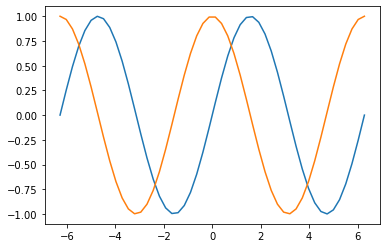

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

axis_x = np.linspace(-2*np.pi, 2*np.pi)
sin_data = np.sin(axis_x)
cos_data = np.cos(axis_x)

plt.plot(axis_x, sin_data)
plt.plot(axis_x, cos_data)
plt.show()

n_rnn = 10
n_sample = len(axis_x)-n_rnn
x_encoder = np.zeros((n_sample, n_rnn))
x_decoder = np.zeros((n_sample, n_rnn))
t_decoder = np.zeros((n_sample, n_rnn))

for i in range(0, n_sample):
    x_encoder[i] = sin_data[i:i+n_rnn]
    x_decoder[i, 1:] = cos_data[i:i+n_rnn-1]
    t_decoder[i] = cos_data[i:i+n_rnn]
    
x_encoder = x_encoder.reshape(n_sample, n_rnn, 1)
x_decoder = x_decoder.reshape(n_sample, n_rnn, 1)
t_decoder = t_decoder.reshape(n_sample, n_rnn, 1)



In [4]:
from keras.models import Model
from keras.layers import Dense, LSTM, Input

n_in = 1
n_mid = 20
n_out = n_in

encoder_input = Input(shape=(n_rnn, n_in))
encoder_lstm = LSTM(n_mid, return_state=True)
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_input)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = Input(shape=(n_rnn, n_in))
decoder_lstm = LSTM(n_mid, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_state)
decoder_dense = Dense(n_out, activation='linear')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(loss="mean_squared_error", optimizer="adam")
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 20), (None,  1760        input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 10, 20), (No 1760        input_4[0][0]                    
                                                                 lstm_2[0][1]               

In [5]:
history = model.fit([x_encoder, x_decoder], t_decoder,
                   batch_size=8,
                   epochs=30)

Epoch 1/30
40/40 [==============================] - 1s 24ms/step - loss: 0.5036
Epoch 2/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4585
Epoch 3/30
40/40 [==============================] - 0s 4ms/step - loss: 0.4230
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 0.3908
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 0.3663
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 0.3451
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 8/30
40/40 [==============================] - 0s 2ms/step - loss: 0.3113
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 10/30
40/40 [==============================] - 0s 2ms/step - loss: 0.2796
Epoch 11/30
40/40 [==============================] - 0s 3ms/step - loss: 0.2626
Epoch 12/30
40/40 [==============================] - 0s 2ms/step - loss: 0.2445
Epoch 13/30
40/40 [=============================

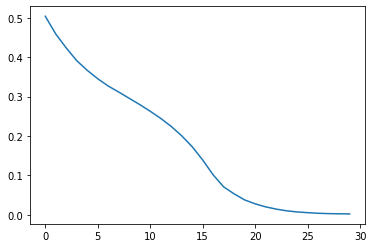

In [6]:
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

In [8]:
encoder_model = Model(encoder_input, encoder_state)

decoder_input = Input(shape=(1, n_in))

decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in_c = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h, decoder_state_in_c]

decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input,
                                                               initial_state=decoder_state_in)

decoder_state = [decoder_state_h, decoder_state_c]

decoder_output = decoder_dense(decoder_output)
decoder_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_state)

In [13]:
def translate(input_data):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, 1))
    translated = []
    
    for i in range(0, n_rnn):
        y, h, c = decoder_model.predict([y_decoder] + state_value)
        y = y[0][0][0]
        translated.append(y)
        y_decoder[0][0][0] = y
        state_value =[h, c]
        
    return translated

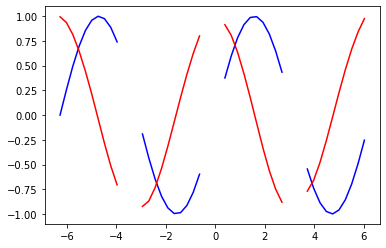

In [14]:
demo_idices = [0, 13, 26, 39]
for i in demo_idices:
    x_demo = x_encoder[i:i+1]
    y_demo = translate(x_demo)
    
    plt.plot(axis_x[i:i+n_rnn], x_demo.reshape(-1), color="b")
    plt.plot(axis_x[i:i+n_rnn], y_demo, color="r")
    
plt.show()